# Exercise 04 Notebook - Convolutional Neural Networks

In this exercise we'll implement different convolutional neural networks, that is AlexNet and ResNet18. Further, we'll use a pretrained model and finetune it to further increase the performance.

1. Load Data
2. Implement AlexNet from Scratch
3. Implement pretrained ResNet18
4. Implement and finetune a pretrained ResNet18

## 1. Load Data

We'll use the Imagenette data set during this exercise. More specifically, we'll use the Imagenette-320 data set. Imagenette is a very small subset of the Imagenet data set which consists of 9469 training samples and 3925 validation examples. Each sample is a 320x320 image, associated with a label from 10 different classes. More information can be found [here](https://github.com/fastai/imagenette)

You can download the dataset [here](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz)

Labels:</br>
0=n01440764='tench',</br>
1=n02102040='English springer',</br>
2=n02979186='cassette player',</br>
3=n03000684='chain saw',</br>
4=n03028079='church',</br>
5=n03394916='French horn',</br>
6=n03417042='garbage truck',</br>
7=n03425413='gas pump',</br>
8=n03445777='golf ball',</br>
9=n03888257='parachute'</br>

Task 1: Download the data set and create a *torch.utils.data.Dataset* class for training and validation set, respectively. </br>
*Hint1 : You can use PyTorch's [ImageFolder](https://pytorch.org/vision/stable/datasets.html#imagefolder) class to create a torch.utils.data.Dataset*.</br>
*Hint2: You need to transform each sample such that each image is of size 224 and each image needs to be a tensor. Use PyTorch's [transforms method](https://pytorch.org/vision/stable/transforms.html#torchvision-transforms)* </br>
*Hint3: Enable GPU runtime as follows: Runtime > Change Runtime type > Hardware accelerator > GPU*

Task 2: Create a DataLoader object with batch size = 8 for training and valid set, respectively<br>
* *Hint: Don't forget to shuffle the DataLoader!* </br>

Task 3: Print the shape of one batch (images and labels) and plot one example with image and label

### Download and unzip data

In [20]:
!wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar zxf /content/imagenette2-320.tgz

In [21]:
import torch

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

True
Tesla T4


### 1.1 Create DataSet (Task 1)

In [22]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder('imagenette2-320/train', transform=transform)
val_dataset = datasets.ImageFolder('imagenette2-320/val', transform=transform)

### 1.2 Create DataLoader (Task 2)

In [23]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

### 1.3 One Example (Task 3)

In [25]:
images, labels = next(iter(train_dl))
print('Shape of the image data of one batch: '+ str(images.shape))
print('Shape of the label tensor of one batch: ' + str(labels.shape))


Shape of the image data of one batch: torch.Size([8, 3, 224, 224])
Shape of the label tensor of one batch: torch.Size([8])


In [24]:
dic = {0: "tench",
        1: "English springer",
        2: "cassette player",
        3: "chain saw",
        4: "church",
        5: "French horn",
        6: "garbage truck",
        7: "gas pump",
        8: "golf ball",
        9: "parachute"
        }

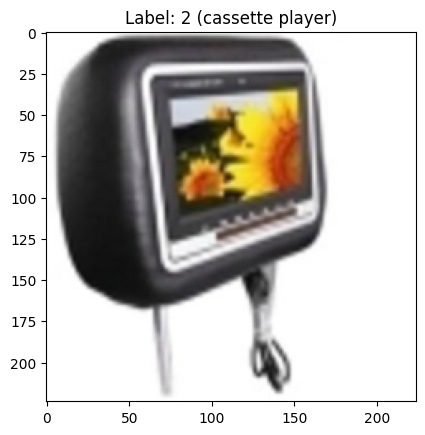

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(image, label):
  plt.imshow(image.permute(1, 2, 0))
  plt.title("Label: " + str(label.item()) + " (" + dic[label.item()] + ")")

random_index = int(np.random.random()*8)
show_image(images[random_index], labels[random_index])

## 2. AlexNet Model from Scratch

We introduced [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) in the lecture. We now want to implement AlexNet from scratch using almost the same architecture as the authors proposed in the original paper and in the ImageNet Large Scale Visual Recognition Competition (ILSVRC)

Task 4: Create a AlexNetFashionCNN class with 5 Convolutional Layers, 3 Pooling Layers and 2 fully connected-layers. 
* First convolutional layer: Kernel size: 11x11, stride:4, padding=2, check the number of input/output channels yourself
* First max pooling layer: Window size: 3x3, stride:2
* Second conv layer: Kernel size: 5x5, stride=1, padding:2, check the number of input/output channels: yourself
* Second max pooling layer: Window size: 3x3, stride:2
* Third conv layer: Kernel size: 3x3, stride=1, padding=1, check the number of input/output channels: yourself
* Fourth conv layer: Kernel size: 3x3, stride=1, padding=1, check the number of input/output channels: yourself
* Fifth conv layer: Kernel size: 3x3, stride=1, padding=1, check the number of input/output channels: yourself
* Third max pooling layer: Window size: 3x3, stride=2
* The ReLU non-linearity is applied to the output of every convolutional and fully-connected layer. (except for the last fully-connected layer!) 
* *Hint 1: Think about the output of the last layer. Should we apply an activation function? If yes, which one is most appropriate?
* *Hint 2: What is the number of neurons in the first fully-connected layer? Try to figure it out by yourself!

Task 5: Forward propagate the first batch to test whether the network is working as expected. 

Task 6: Implement a method which serves as a training loop to train the network
* The method should expect the following parameters: the model which should be trained, number of epochs, optimizer, and loss function
* The method should return the training and test accuracy of each epoch. Optionally, print the accuracy of training and validation for each epoch during training
* This is actually the most difficult part, have a look at the other notebooks which we have already provided

Task 7: Create an optimizer object (such as stochastic gradient descent), define the number of epochs and train the AlexNetFashionCNN
* Play with the number of epochs, and the learning rate of the optimizer until you are satisfied with the results

### 2.1 AlexNetFashionCNN (Task 4)

In [27]:
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import random
from tqdm.notebook import tqdm
from torch.nn import LogSoftmax

In [28]:
class SimpleCnn(nn.Module):
    def __init__(self):
        super(SimpleCnn, self).__init__()
        #First convolutional layer: Kernel size: 11x11, stride:4, padding=2, check the number of input/output channels yourself
        self.conv_1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.act1 = nn.ReLU()
        #First max pooling layer: Window size: 3x3, stride:2
        self.pooling_1 = nn.MaxPool2d(kernel_size=3, stride=2)

        #Second conv layer: Kernel size: 5x5, stride=1, padding:2, check the number of input/output channels: yourself
        self.conv_2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.act2 = nn.ReLU()
        #Second max pooling layer: Window size: 3x3, stride:2
        self.pooling_2 = nn.MaxPool2d(kernel_size=3, stride=2)

        #Third conv layer: Kernel size: 3x3, stride=1, padding=1, check the number of input/output channels: yourself
        self.conv_3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()

        #Fourth conv layer: Kernel size: 3x3, stride=1, padding=1, check the number of input/output channels: yourself
        self.conv_4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()

        #Fifth conv layer: Kernel size: 3x3, stride=1, padding=1, check the number of input/output channels: yourself
        self.conv_5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.act5 = nn.ReLU()
        #Third max pooling layer: Window size: 3x3, stride=2
        self.pooling_5 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Fully-connected Layer
        self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
        self.act6 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=4096, out_features=10) #10 output features
        #self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, X):
        
        feature_map_1 = self.conv_1(X)                                          
        nonlinear_feature_map_1 = self.act1(feature_map_1)                         
        pooled_nonlinear_feature_map_1 = self.pooling_1(nonlinear_feature_map_1)  

        feature_map_2 = self.conv_2(pooled_nonlinear_feature_map_1)             
        nonlinear_feature_map_2 = self.act2(feature_map_2)                        
        pooled_nonlinear_feature_map_2 = self.pooling_2(nonlinear_feature_map_2)  

        feature_map_3 = self.conv_3(pooled_nonlinear_feature_map_2)             
        nonlinear_feature_map_3 = self.act3(feature_map_3)                         

        feature_map_4 = self.conv_4(nonlinear_feature_map_3)                    
        nonlinear_feature_map_4 = self.act4(feature_map_4)                         

        feature_map_5 = self.conv_5(nonlinear_feature_map_4)                    
        nonlinear_feature_map_5 = self.act5(feature_map_5)                         
        pooled_nonlinear_feature_map_5 = self.pooling_5(nonlinear_feature_map_5)  
        

        feature_map_flattened = pooled_nonlinear_feature_map_5.flatten(1)       
        output = self.fc1(feature_map_flattened)                                
        nonlinear_output = self.act6(output)                                       
        output = self.fc2(nonlinear_output)                                     
        #output = self.logSoftmax(output)
        
        return output

In [29]:
cnn = SimpleCnn()  # Create object from class SimpleCnn
# pass the model to the gpu
cnn.to(device)

SimpleCnn(
  (conv_1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (act1): ReLU()
  (pooling_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pooling_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv_4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv_5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pooling_5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (act6): ReLU()
  (fc2): Linear(in_features=4096, out_features=10, bias=True)
)

### 2.2 Forward Propagation (first batch) (Task 5)

In [30]:
##get first batch
#first_batch = next(iter(train_dl))
batch_num = 0
trainCorrect = 0
trainTotal = 0
for (images, labels) in train_dl:
  #print(images.shape)
  #print(labels.shape)
  batch_num +=1
  if batch_num == 1:
    (images, labels) = (images.to(device), labels.to(device))
    pred = cnn(images)

    trainCorrect += (pred.argmax(1) == labels).type(torch.float).sum().item()
    trainTotal += labels.size(0)
    
    print('Prediction: ' + str(pred))
    print('Labels: ' + str(labels))

    #print(torch.sum(torch.eq(pred, labels)).item())
    print('Prediction ARGMAX : ' + str(torch.argmax(pred, dim=1)))
    print('Prediction Correct? : ' + str((pred.argmax(1) == labels).type(torch.float)))
    
    print('Correct predicted: ' + str(trainCorrect))
    print('Total predicted: ' + str(trainTotal))
    
  else:
    break

Prediction: tensor([[ 0.0115,  0.0150, -0.0141,  0.0054,  0.0064, -0.0212, -0.0190,  0.0077,
         -0.0038, -0.0074],
        [ 0.0108,  0.0135, -0.0134,  0.0045,  0.0073, -0.0205, -0.0186,  0.0067,
         -0.0056, -0.0068],
        [ 0.0112,  0.0151, -0.0136,  0.0050,  0.0059, -0.0208, -0.0195,  0.0079,
         -0.0030, -0.0074],
        [ 0.0114,  0.0148, -0.0139,  0.0053,  0.0067, -0.0205, -0.0196,  0.0076,
         -0.0045, -0.0071],
        [ 0.0120,  0.0146, -0.0140,  0.0053,  0.0061, -0.0203, -0.0194,  0.0076,
         -0.0041, -0.0067],
        [ 0.0119,  0.0154, -0.0137,  0.0058,  0.0071, -0.0210, -0.0194,  0.0080,
         -0.0041, -0.0066],
        [ 0.0119,  0.0142, -0.0141,  0.0054,  0.0060, -0.0216, -0.0194,  0.0082,
         -0.0044, -0.0070],
        [ 0.0132,  0.0154, -0.0139,  0.0058,  0.0070, -0.0205, -0.0195,  0.0071,
         -0.0051, -0.0075]], device='cuda:0', grad_fn=<AddmmBackward0>)
Labels: tensor([8, 2, 7, 9, 5, 8, 7, 4], device='cuda:0')
Prediction ARG

### 2.3 Training Loop (Task 6)

In [31]:
# To get a better idea of how well your model performs
# you should implement an accuracy function that is
# called after each epoch of your training loop
def accuracy(out, yb):    
    return (out.argmax(1) == yb).type(torch.float).sum().item()

In [32]:
def train(net, train_dl, val_dl, epochs, optimizer, loss_func):
    # Set the model on train mode
    net.train()
    # Define arrays for evaluation
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    # Loop over all epochs
    for epoch in tqdm(range(epochs)):
        # Reset evaluation variables
        train_loss, valid_loss = 0, 0
        train_acc, valid_acc = 0, 0
        train_correct, valid_correct = 0, 0
        train_total, valid_total = 0, 0

        # Training loop
        for (images, labels) in train_dl:        
          # Push batch to GPU
          (images, labels) = (images.to(device), labels.to(device))
          optimizer.zero_grad()

          # Predict
          pred = net(images)        
          # Calculate loss and adjust weights            
          loss = loss_func(pred, labels)
          
          loss.backward()
          optimizer.step()

          # Calculate evaluation metrics
          train_loss += loss.item()
          train_correct += accuracy(pred, labels)
          train_total += labels.size(0)

        # Evaluation loop
        net.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for (images, labels) in val_dl:            
              # Push batch to GPU
              (images, labels) = (images.to(device), labels.to(device))

              # Predict
              pred = net(images)

              # Calculate evaluation metrics                
              loss = loss_func(pred, labels)
              valid_loss += loss.item()
              valid_correct += accuracy(pred, labels)
              valid_total += labels.size(0)
              

        # Calculations for evaluations
        train_loss /= len(train_dl)
        train_acc = train_correct / train_total
        valid_loss /= len(val_dl)
        valid_acc = valid_correct / valid_total

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTraining Acc: {train_acc:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Acc: {valid_acc:.6f}')

    # Return losses for plotting
    return train_losses, valid_losses, train_accs, valid_accs


### 2.4 Training (Task 7)

In [33]:
epochs = 20
lr = 0.0025
optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum = 0.9)
loss_func = nn.CrossEntropyLoss()  # Cross Entropy Loss
#loss_func = nn.NLLLoss()

In [34]:
# Execute the train function and train the model.
train_losses, valid_losses, train_accs, valid_accs = train(cnn, train_dl, val_dl, epochs, optimizer, loss_func)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.285883 	Training Acc: 0.128841 	Validation Loss: 2.248232 	Validation Acc: 0.132739
Epoch: 2 	Training Loss: 2.114168 	Training Acc: 0.245221 	Validation Loss: 1.918750 	Validation Acc: 0.326624
Epoch: 3 	Training Loss: 1.749704 	Training Acc: 0.400148 	Validation Loss: 1.689770 	Validation Acc: 0.420637
Epoch: 4 	Training Loss: 1.517891 	Training Acc: 0.496040 	Validation Loss: 1.582717 	Validation Acc: 0.471083
Epoch: 5 	Training Loss: 1.303273 	Training Acc: 0.573133 	Validation Loss: 1.315429 	Validation Acc: 0.571465
Epoch: 6 	Training Loss: 1.133159 	Training Acc: 0.622663 	Validation Loss: 1.299017 	Validation Acc: 0.572739
Epoch: 7 	Training Loss: 0.971341 	Training Acc: 0.673778 	Validation Loss: 1.341078 	Validation Acc: 0.575032
Epoch: 8 	Training Loss: 0.766346 	Training Acc: 0.744535 	Validation Loss: 1.337760 	Validation Acc: 0.612994
Epoch: 9 	Training Loss: 0.577349 	Training Acc: 0.807371 	Validation Loss: 1.423240 	Validation Acc: 0.584204
E

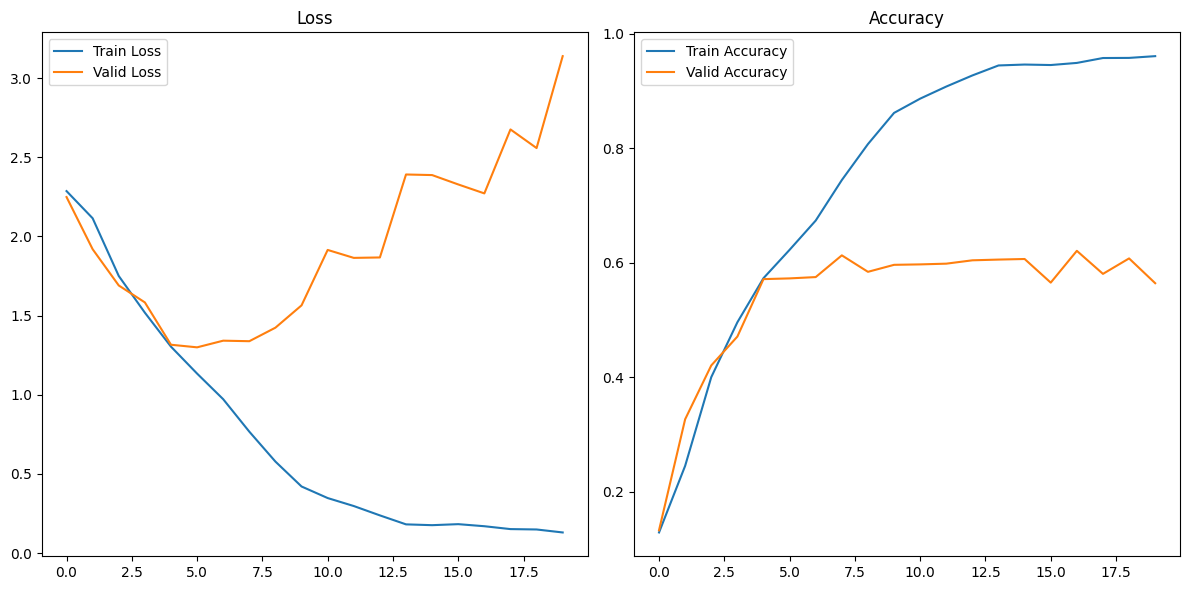

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Train/Valid Loss
ax1.set_title('Loss')
ax1.plot(list(train_losses), label='Train Loss')
ax1.plot(list(valid_losses), label='Valid Loss')
ax1.legend()

# Plot 2: Train/Valid Accuracy
ax2.set_title('Accuracy')
ax2.plot(list(train_accs), label='Train Accuracy')
ax2.plot(list(valid_accs), label='Valid Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Pretrained ResNet18

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Hence, we'll now use a ResNet18 model pretrained on ImageNet.

Task 10: Download the ResNet18 architecture and weights from PyTorch, create a pretrained ResNet18 CNN, and replace the last fully-connected layer
* Again, you can use PyTorch's [torchvision-models](https://pytorch.org/vision/stable/models.html#torchvision-models). But this time, set pretrained=True in order to download the weights from the pretrained model
* *Hint: Note that the ResNet18 was pretrained on the ImageNet data set where the task was to classify 1000 different labels. Here we will only need 10 classes. Thus, you need to **replace** the last fully-connected layer with one which only produces 10 outputs instead of 1000.*

Task 11: Use the *fit method* defined above to train the pretrained ResNet18 model
* Again, play with the optimizer and the number of epochs until you are satisfied with the results (in terms of accuracy on training and validation set)

In [38]:
import torchvision.models as models

### 3.1 Create Pretrained ResNet18 Model (Task 10)

In [39]:
resnetcnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #download the pretrained model
num_classes = 10 #we use 10 output classes
num_features = resnetcnn.fc.in_features #input features in the fully connected layer
fc_layer = nn.Linear(num_features, num_classes) #new fc layer
resnetcnn.fc = fc_layer # Replace the last fully-connected layer

resnetcnn.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 233MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3.2 Pretrained ResNet18 Training (Task 11)

In [40]:
epochs = 15
lr = 0.00025
optimizer = torch.optim.SGD(resnetcnn.parameters(), lr=lr, momentum = 0.9)
#optimizer = torch.optim.Adam(resnetcnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()  # Cross Entropy Loss
#loss_func = nn.NLLLoss()

In [41]:
# Execute the train function and train the model.
train_losses, valid_losses, train_accs, valid_accs = train(resnetcnn, train_dl, val_dl, epochs, optimizer, loss_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.491577 	Training Acc: 0.877284 	Validation Loss: 0.103402 	Validation Acc: 0.972484
Epoch: 2 	Training Loss: 0.091851 	Training Acc: 0.970535 	Validation Loss: 0.076762 	Validation Acc: 0.976051
Epoch: 3 	Training Loss: 0.038284 	Training Acc: 0.988700 	Validation Loss: 0.088019 	Validation Acc: 0.971720
Epoch: 4 	Training Loss: 0.016179 	Training Acc: 0.995564 	Validation Loss: 0.074551 	Validation Acc: 0.976306
Epoch: 5 	Training Loss: 0.006141 	Training Acc: 0.998416 	Validation Loss: 0.078048 	Validation Acc: 0.975287
Epoch: 6 	Training Loss: 0.001257 	Training Acc: 1.000000 	Validation Loss: 0.059300 	Validation Acc: 0.982675
Epoch: 7 	Training Loss: 0.000360 	Training Acc: 1.000000 	Validation Loss: 0.060555 	Validation Acc: 0.982420
Epoch: 8 	Training Loss: 0.000230 	Training Acc: 1.000000 	Validation Loss: 0.061077 	Validation Acc: 0.982420
Epoch: 9 	Training Loss: 0.000174 	Training Acc: 1.000000 	Validation Loss: 0.062665 	Validation Acc: 0.982166
E

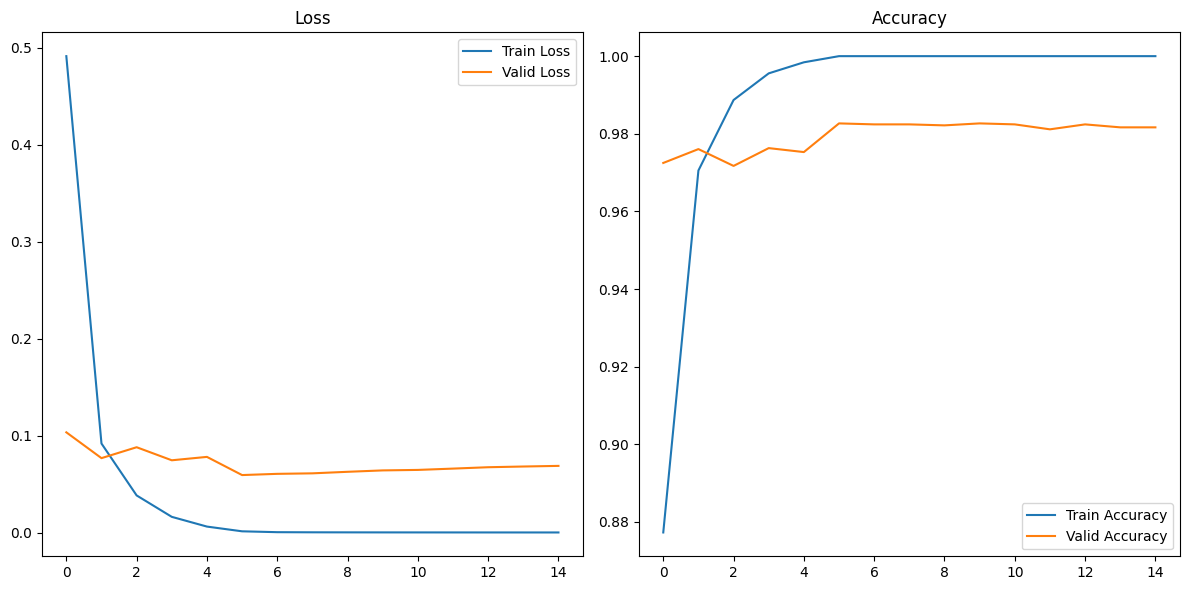

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Train/Valid Loss
ax1.set_title('Loss')
ax1.plot(list(train_losses), label='Train Loss')
ax1.plot(list(valid_losses), label='Valid Loss')
ax1.legend()

# Plot 2: Train/Valid Accuracy
ax2.set_title('Accuracy')
ax2.plot(list(train_accs), label='Train Accuracy')
ax2.plot(list(valid_accs), label='Valid Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Finetuning Pretrained ResNet18

In the previous exercise (Chapter 4), we retrained the entire pretrained ResNet18 model using the Imagenette data set. Although the results were already pretty good, it might be better to only train the custom, final fully-connected layer. Remember, that every layer in a pretrained model is already optimized except for the custom final fully-connected layer which is randomly initialized. Thus, in this exercise we want to **only train the custom fully-connected layer** (only update the weights of the custom fully-connected layer) and keep the other layers (and weigts).

Task 12: Download the ResNet18 architecture and weights from PyTorch, create a pretrained ResNet18 CNN, freeze all layers, and replace the last fully-connected layer
* *Hint 1: In order to "freeze" a layer, you need to set its requires_grad Parameter to False
* *Hint 2: First freeze all layers, than add the custom, final fully-connected layer

Task 13: Use the *fit method* defined above to train only the last layer of the pretrained ResNet18 model
* Note how the training is much faster (as we don't need to compute the gradients for each layer!)

### 4.1 Create Pretrained ResNet18 Model (Task 12)

In [43]:
resnetcnn12 = models.resnet18(pretrained=True) #download the pretrained model
# Freeze  layers
for param in resnetcnn12.parameters():
    param.requires_grad = False

# Replace the last fully-connected layer
num_features = resnetcnn12.fc.in_features
resnetcnn12.fc = nn.Linear(num_features, 10)  # Replace num_classes with the desired number of output classes

# Optional: Initialize the new fully-connected layer
nn.init.xavier_uniform_(resnetcnn12.fc.weight)
nn.init.zeros_(resnetcnn12.fc.bias)

resnetcnn12.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.2 Pretrained ResNet18 Fine Tuning (Task 13)

In [44]:
epochs = 15
lr = 0.0025
optimizer = torch.optim.SGD(resnetcnn12.parameters(), lr=lr, momentum = 0.9)
#optimizer = torch.optim.Adam(resnetcnn12.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()  # Cross Entropy Loss
#loss_func = nn.NLLLoss()

In [45]:
# Execute the train function and train the model.
train_losses, valid_losses, train_accs, valid_accs = train(resnetcnn12, train_dl, val_dl, epochs, optimizer, loss_func)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.367767 	Training Acc: 0.885521 	Validation Loss: 0.082865 	Validation Acc: 0.972229
Epoch: 2 	Training Loss: 0.066778 	Training Acc: 0.977717 	Validation Loss: 0.074994 	Validation Acc: 0.975541
Epoch: 3 	Training Loss: 0.044557 	Training Acc: 0.985954 	Validation Loss: 0.072954 	Validation Acc: 0.976051
Epoch: 4 	Training Loss: 0.033112 	Training Acc: 0.991551 	Validation Loss: 0.068724 	Validation Acc: 0.976561
Epoch: 5 	Training Loss: 0.027177 	Training Acc: 0.993030 	Validation Loss: 0.058723 	Validation Acc: 0.980637
Epoch: 6 	Training Loss: 0.022775 	Training Acc: 0.994086 	Validation Loss: 0.055360 	Validation Acc: 0.981911
Epoch: 7 	Training Loss: 0.019314 	Training Acc: 0.995776 	Validation Loss: 0.062225 	Validation Acc: 0.979108
Epoch: 8 	Training Loss: 0.016689 	Training Acc: 0.996409 	Validation Loss: 0.062007 	Validation Acc: 0.980892
Epoch: 9 	Training Loss: 0.014707 	Training Acc: 0.998099 	Validation Loss: 0.057310 	Validation Acc: 0.981146
E

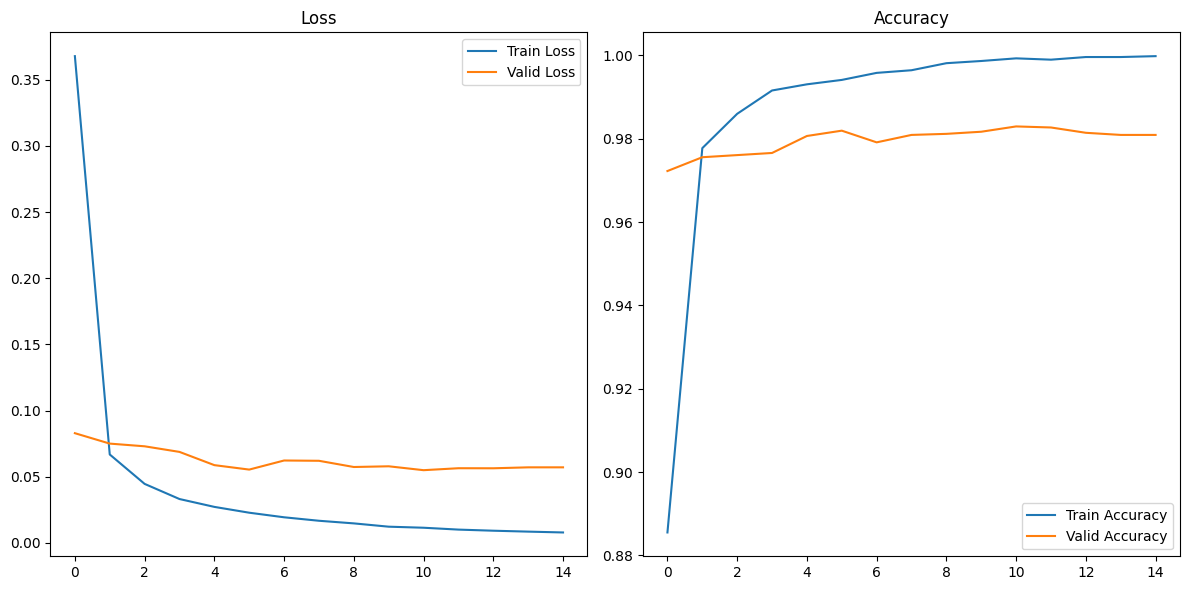

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Train/Valid Loss
ax1.set_title('Loss')
ax1.plot(list(train_losses), label='Train Loss')
ax1.plot(list(valid_losses), label='Valid Loss')
ax1.legend()

# Plot 2: Train/Valid Accuracy
ax2.set_title('Accuracy')
ax2.plot(list(train_accs), label='Train Accuracy')
ax2.plot(list(valid_accs), label='Valid Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()